### Notebook for the manual annotation of cell states and excluding stromal

- **Developed by:** Carlos Talavera-López Ph.D
- **Würzburg Institute for Systems Immunology - Faculty of Medicine - Julius-Maximilian-Universität Würzburg**
- v231127

### Import required modules

In [1]:
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

from SCCAF import SCCAF_assessment, plot_roc

### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.7
scanpy      1.10.1
-----
PIL                 10.3.0
SCCAF               NA
asttokens           NA
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.8.1
decorator           5.1.1
distutils           3.12.3
executing           2.0.1
h5py                3.11.0
igraph              0.11.5
ipykernel           6.29.4
ipywidgets          8.1.3
jedi                0.19.1
joblib              1.4.2
kiwisolver          1.4.5
legacy_api_wrap     NA
llvmlite            0.42.0
louvain             0.8.2
matplotlib          3.9.0
mpl_toolkits        NA
natsort             8.4.0
numba               0.59.1
numexpr             2.10.0
numpy               1.26.4
packaging           24.0
pandas              2.2.2
parso               0.8.4
patsy               0.5.6
pkg_resources       NA
platformdirs        4.2.2
prompt_toolkit      3.0.44
psutil              5.9.8
pure_eval           0.2.2
pydev_ipython  

### Read in Healthy-CTRL dataset

In [3]:
adata = sc.read_h5ad('../../../data/heart_mm_nuclei-23-0092_scANVI-Myeloid_ctl240502.raw.h5ad') 
adata

AnnData object with n_obs × n_vars = 41716 × 16060
    obs: 'orig.ident', 'Age_group', 'BMI', 'COVID_severity', 'COVID_status', 'Ethnicity', 'Group', 'Sex', 'annotation_broad', 'annotation_detailed', 'sample_id', 'seed_labels', 'donor', 'cell_states', 'sample', 'cell_source', 'genotype', 'nCount_HTO', 'nFeature_HTO', 'HTO_classification', 'Library', 'CD45_Annotation', 'cell_type', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'scrublet_score', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'MPC_Annotation', 'compartment'
    var: 'gene_ids-DMD_immune-DMD', 'feature_types-DMD_immune-DMD', 'genome-DMD_immune-DMD', 'mt-DMD_immune-DMD', 'ribo-DMD_immune-DMD', 'n_cells_by_counts-DMD_immune-DMD', 'mean_counts-DMD_immune-DMD', 'pct_dropout_by_counts-DMD_immune-DMD', 'total_counts-DMD

### Visualise manifold with `scANVI` annotation

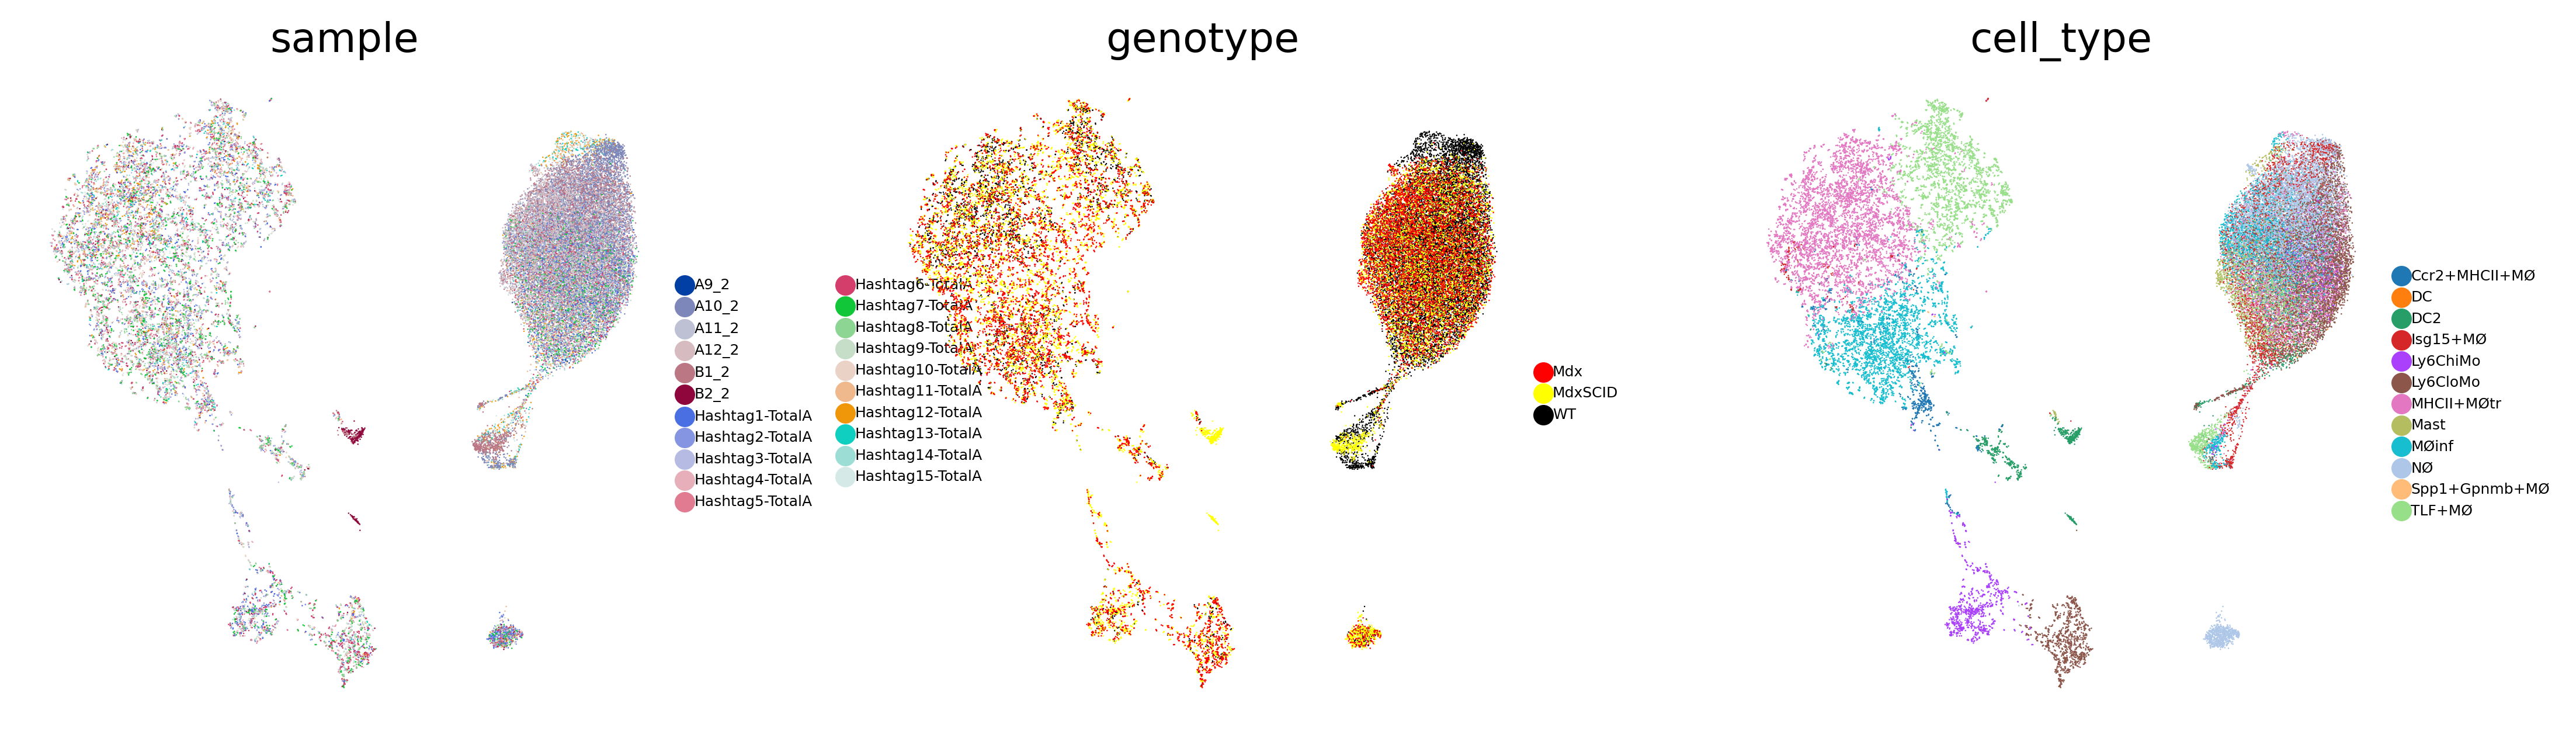

In [4]:
sc.pl.umap(adata, frameon = False, color = ['sample', 'genotype', 'cell_type'], size = 1, legend_fontsize = 5, ncols = 3)

### Cluster manifold using `leiden` with resolution of `1.0`

In [ ]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 150, metric = 'minkowski')
sc.tl.leiden(adata, resolution = 0.5, random_state = 1712)
sc.pl.umap(adata, frameon = False, color = ['genotype', 'cell_type', 'leiden'], size = 0.8, legend_fontsize = 5, ncols = 3)

### Evaluate clustering accuracy with `SCCAF`

In [ ]:
sc.pl.umap(adata, frameon = False, color = ['cell_type', 'leiden'], size = 0.8, legend_fontsize = 5, ncols = 3, legend_loc = 'on data')

In [ ]:
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)

In [ ]:
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)
plt.rcParams["figure.figsize"] = (16,6)
plt.show()

In [ ]:
adata

### Rename cluster based on the cell type annotation

In [ ]:
sc.pl.umap(adata, frameon = False, color = ['leiden', 'cell_type'], size = 1, legend_fontsize = 5, ncols = 3, legend_loc = 'on data')

In [ ]:
adata.obs['leiden'].cat.categories

In [ ]:
adata.obs['cell_states'] = adata.obs['leiden']
adata.obs['cell_states'] = adata.obs['cell_type'].cat.rename_categories(['FB', 'EC1', 'Mono', 'CM1', 'EC4', 'PC', 'CM2', 'mesCM', 'EC8', 'Myeloid1', 'EC10', 'MØ', 'lnEC',
       'mesFB', 'CD8+T', 'B', 'Myeloid2', 'CM3'])
sc.pl.umap(adata, frameon = False, color = ['leiden', 'cell_type', 'C_scANVI'], size = 1, legend_fontsize = 5, ncols = 3, legend_loc = 'on data')

### Calculate cluster-specific marker genes using _Wilcoxon's Rank Sum Test_

In [ ]:
adata_log = adata.copy()
adata_log

In [ ]:
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)

In [ ]:
sc.tl.rank_genes_groups(adata_log, 'cell_type', method = 'wilcoxon', n_genes = 100, use_raw = False)
result = adata_log.uns['rank_genes_groups']
groups = result['names'].dtype.names
wilcox_markers = pd.DataFrame(
{group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names','logfoldchanges', 'pvals_adj']})
wilcox_markers.head(10)

In [ ]:
wilcox_markers.to_csv('../../../data/heart_mm_nuclei-23-0092_Myeloid-CellTypes_ctl240502_WilcoxRST_markers.csv', sep = ',', index = False)

### Export annotated object

In [ ]:
adata